# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


In [176]:
from time import time

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [2]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 13 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [3]:
X_sparse_10users.shape

(13084, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.**

In [5]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [6]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [7]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [16]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)

CPU times: user 40 ms, sys: 64 ms, total: 104 ms
Wall time: 3.81 s


In [168]:
knn_cv_scores

array([ 0.52993131,  0.53130121,  0.53245902])

In [17]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [18]:
%%time
knn_valid_acc = accuracy_score(knn.predict(X_valid), y_valid)

CPU times: user 728 ms, sys: 21.5 s, total: 22.2 s
Wall time: 29.9 s


In [20]:
knn_valid_acc

0.5560366785532348

**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [21]:
write_answer_to_file("{} {}".format(round(float(np.mean(knn_cv_scores)), 3), 
                                    round(knn_valid_acc, 3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=7)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [35]:
forest.oob_score_

0.69993448351168375

In [36]:
rf_valid_acc = accuracy_score(forest.predict(X_valid), y_valid)
rf_valid_acc

0.71879775853285788

**Запишите в файл *answer4_2.txt* доли правильных ответов для RandomForestClassifier при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [37]:
write_answer_to_file("{} {}".format(round(forest.oob_score_, 3), round(rf_valid_acc, 3)),
                     'answer4_2.txt')

**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [38]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [39]:
logit = LogisticRegression(random_state=7, n_jobs=-1)

In [45]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)
print(logit_cv_scores)
logit.fit(X_train, y_train)

[ 0.73928688  0.7394297   0.73213115]
CPU times: user 664 ms, sys: 64 ms, total: 728 ms
Wall time: 1.23 s


In [46]:
accuracy_score(logit.predict(X_valid), y_valid)

0.75700458481915434

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).**

**С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.**

**Нарисуйте кривые валидации по параметру С.**

In [133]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=7, n_jobs=-1, cv=skf)

logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1.2 s, sys: 956 ms, total: 2.15 s
Wall time: 11 s


In [134]:
logit_grid_searcher1.scores_.values()[0]

array([[ 0.29865882,  0.73438011,  0.73438011,  0.72554792,  0.7232581 ,
         0.71998692,  0.71835132,  0.71900556,  0.71900556,  0.71671573],
       [ 0.29727958,  0.73025238,  0.73025238,  0.72205834,  0.71746968,
         0.71091445,  0.71156998,  0.70960341,  0.70829236,  0.70829236],
       [ 0.30459016,  0.72229508,  0.71934426,  0.7147541 ,  0.71442623,
         0.71147541,  0.7095082 ,  0.70786885,  0.70819672,  0.70655738]])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [135]:
logit_mean_cv_scores1 = list(mean([i.mean(axis=0) for i in logit_grid_searcher1.scores_.values()], axis=0))
logit_mean_cv_scores1

[0.300176186744121,
 0.72897585648581309,
 0.72799224992843592,
 0.7207867875627183,
 0.71838466925078914,
 0.71412559312992219,
 0.71314316620209239,
 0.71215927406166446,
 0.71183154849287289,
 0.71052182486297055]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [136]:
print("C:", logit_c_values1[logit_mean_cv_scores1.index(max(logit_mean_cv_scores1))], "score:", max(logit_mean_cv_scores1))

C: 1111.1112 score: 0.728975856486


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

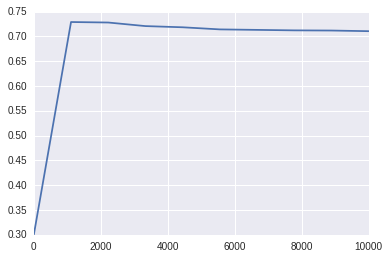

In [137]:
plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(1e-3, 1, 30). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [138]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=7, n_jobs=-1, cv=skf)

logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.24 s, sys: 1.01 s, total: 2.26 s
Wall time: 27.3 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 30 параметров С.

In [139]:
logit_mean_cv_scores2 = list(mean([i.mean(axis=0) for i in logit_grid_searcher2.scores_.values()], axis=0))
logit_mean_cv_scores2

[0.46942737207768354,
 0.68093401722599756,
 0.70462905188112657,
 0.71522013214554192,
 0.72046020580255721,
 0.72504740152230152,
 0.72701229021459368,
 0.72887035601124484,
 0.73018050850786587,
 0.73138162164127696,
 0.73192710453252052,
 0.73247369541147767,
 0.73345698007274496,
 0.73334708297609741,
 0.733674201065728,
 0.73389299473405978,
 0.73433015320400508,
 0.73487599332013365,
 0.73531247266908406,
 0.73498471127937592,
 0.73563966240054846,
 0.73520279000579614,
 0.73563916189199596,
 0.73553055139550438,
 0.7355307658288639,
 0.73542129759893515,
 0.73542133341985205,
 0.73563959075871455,
 0.73520264672212854,
 0.73509385761319468]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [140]:
print("C:", logit_c_values2[logit_mean_cv_scores2.index(max(logit_mean_cv_scores2))], "score:", \
                                                                      max(logit_mean_cv_scores2))

C: 0.689965517241 score: 0.735639662401


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

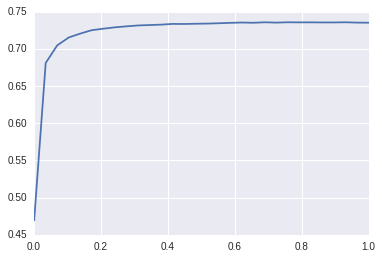

In [141]:
plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [142]:
logit_cv_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)
logit_cv_acc

0.75267447784004071

**Запишите в файл *answer4_3.txt* доли правильных ответов для logit_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [143]:
write_answer_to_file("{} {}".format(round(float(np.max(logit_mean_cv_scores2)), 3), 
                                    round(logit_cv_acc, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [145]:
from sklearn.svm import LinearSVC

In [147]:
svm = LinearSVC(C=1, random_state=7)
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [151]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf)
svm_cv_scores

array([ 0.73536147,  0.72304163,  0.72131148])

In [150]:
accuracy_score(svm.predict(X_valid), y_valid)

0.7516556291390728

**С помощью GridSearchCV подберите параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [152]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 49.1 s, sys: 0 ns, total: 49.1 s
Wall time: 49.1 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [155]:
print(svm_grid_searcher1.best_params_)
print(svm_grid_searcher1.best_score_)

{'C': 3333.3334000000004}
0.655710853898


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

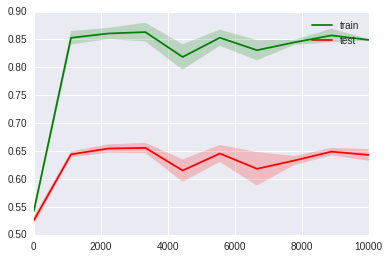

In [156]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C. **

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [160]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 27s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [161]:
print(svm_grid_searcher2.best_params_)
print(svm_grid_searcher2.best_score_)

{'C': 0.069896551724137931}
0.737278881852


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

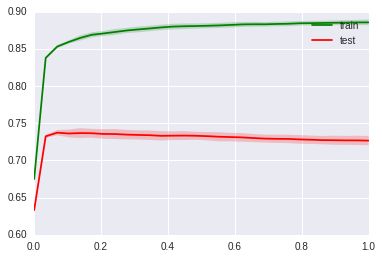

In [162]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [164]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.predict(X_valid), y_valid)
svm_cv_acc

0.76184411614875192

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [165]:
write_answer_to_file("{} {}".format(round(svm_grid_searcher2.best_score_, 3), 
                                    round(svm_cv_acc, 3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации C.**

**Определите функцию model_assessment, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с train_test_split должно быть стратифицированным. Не теряйте нигде random_state.**

In [185]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, 
                     random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start = time()
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    
    estimator.fit(X_train, y_train)
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv)
    accuracy = accuracy_score(estimator.predict(X_valid), y_valid)
    
    end = time()
    
    return dict({"mean CV-accuracy": cv_scores.mean(), "accuracy": accuracy, "time": str(round((end - start), 1)) + " seconds"})


**Убедитесь, что функция работает.**

In [187]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'capstone_websites_data/X_sparse_10users.pkl',
        'capstone_websites_data/y_10users.pkl', skf, random_state=7, test_size=0.3))

{'accuracy': 0.76184411614875192, 'mean CV-accuracy': 0.73727543146114261, 'time': '1.2 seconds'}


**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, svm\_grid\_searcher2.best\_estimator\_) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем скромном маке этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [191]:
%%time
estimator = svm_grid_searcher2.best_estimator_

output = {}
for num_users in [10]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length):
            path_to_X_pkl = 'capstone_websites_data/X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
            path_to_y_pkl = 'capstone_websites_data/y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
            results = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3)
            output[str(num_users) + "users_s" + str(session_length) + "_w" + str(window_size)] = results
            print("Num_users:", num_users, "\n", "session_length:", session_length, "\n", \
                  "window_size:", window_size, "\n", "Results:", results, "\n")

Num_users: 10 
 session_length: 15 
 window_size: 10 
 Results: {'accuracy': 0.82271944922547335, 'mean CV-accuracy': 0.80436299001715328, 'time': '2.1 seconds'} 

Num_users: 10 
 session_length: 10 
 window_size: 10 
 Results: {'accuracy': 0.76184411614875192, 'mean CV-accuracy': 0.73727543146114261, 'time': '1.2 seconds'} 

Num_users: 10 
 session_length: 15 
 window_size: 7 
 Results: {'accuracy': 0.84335060449050081, 'mean CV-accuracy': 0.8304583055496142, 'time': '2.9 seconds'} 

Num_users: 10 
 session_length: 10 
 window_size: 7 
 Results: {'accuracy': 0.78222462592392283, 'mean CV-accuracy': 0.77354420981568361, 'time': '1.6 seconds'} 

Num_users: 10 
 session_length: 7 
 window_size: 7 
 Results: {'accuracy': 0.72577592732778196, 'mean CV-accuracy': 0.7132306251333983, 'time': '0.9 seconds'} 

Num_users: 10 
 session_length: 15 
 window_size: 5 
 Results: {'accuracy': 0.85484070906160903, 'mean CV-accuracy': 0.85309919525367606, 'time': '3.8 seconds'} 

Num_users: 10 
 session

**Запишите в файл *answer4_5.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_10users_s15_w5*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [198]:
output["10users_s15_w5"]

{'accuracy': 0.85484070906160903,
 'mean CV-accuracy': 0.85309919525367606,
 'time': '3.8 seconds'}

In [196]:
write_answer_to_file("{} {}".format(round(output["10users_s15_w5"]["mean CV-accuracy"], 3), 
                                    round(output["10users_s15_w5"]["accuracy"], 3)),
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [202]:
%%time
estimator = svm_grid_searcher2.best_estimator_

output150 = {}
for num_users in [150]:
    for window_size, session_length in [(5,5), (7,7), (10,10)]:
        if window_size <= session_length and (window_size, session_length):
            path_to_X_pkl = 'capstone_websites_data/X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
            path_to_y_pkl = 'capstone_websites_data/y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
            results = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3)
            output150[str(num_users) + "users_s" + str(session_length) + "_w" + str(window_size)] = results
            print("Num_users:", num_users, "\n", "session_length:", session_length, "\n", \
                  "window_size:", window_size, "\n", "Results:", results, "\n")

Num_users: 150 
 session_length: 5 
 window_size: 5 
 Results: {'accuracy': 0.37600694882248281, 'mean CV-accuracy': 0.36404389655716818, 'time': '220.9 seconds'} 

Num_users: 150 
 session_length: 7 
 window_size: 7 
 Results: {'accuracy': 0.41213569918175968, 'mean CV-accuracy': 0.39783864020327425, 'time': '207.4 seconds'} 

Num_users: 150 
 session_length: 10 
 window_size: 10 
 Results: {'accuracy': 0.44566214700784995, 'mean CV-accuracy': 0.42888083119131698, 'time': '184.7 seconds'} 

CPU times: user 10min 7s, sys: 5.89 s, total: 10min 12s
Wall time: 10min 13s


In [203]:
output150

{'150users_s10_w10': {'accuracy': 0.44566214700784995,
  'mean CV-accuracy': 0.42888083119131698,
  'time': '184.7 seconds'},
 '150users_s5_w5': {'accuracy': 0.37600694882248281,
  'mean CV-accuracy': 0.36404389655716818,
  'time': '220.9 seconds'},
 '150users_s7_w7': {'accuracy': 0.41213569918175968,
  'mean CV-accuracy': 0.39783864020327425,
  'time': '207.4 seconds'}}

**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [206]:
write_answer_to_file("{} {}".format(round(output150["150users_s10_w10"]["mean CV-accuracy"], 3), 
                                    round(output150["150users_s10_w10"]["accuracy"], 3)), 
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 10 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [207]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [208]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=7, stratify=y_150users)

**Обучите LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент multi_class='ovr'. Как всегда, где возможно, указывайте n_jobs=-1 и random_state=7.**

In [212]:
logit_grid_searcher2.C_[0]

0.68996551724137933

In [215]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.C_[0]], cv=skf, n_jobs=-1, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 2min 43s, sys: 1min 22s, total: 4min 5s
Wall time: 4min 9s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [221]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()

User 515.0, CV score: 0.99409047725
User 2902.0, CV score: 0.996668361549
User 6.0, CV score: 0.995739972451
User 13.0, CV score: 0.996198851281
User 15.0, CV score: 0.994920630834
User 16.0, CV score: 0.991316609688
User 533.0, CV score: 0.993642853621
User 28.0, CV score: 0.989404915446
User 1054.0, CV score: 0.996340828337
User 31.0, CV score: 0.994243565885
User 33.0, CV score: 0.993282117551
User 1371.0, CV score: 0.992987298385
User 39.0, CV score: 0.987111062147
User 46.0, CV score: 0.997837373236
User 49.0, CV score: 0.995106508496
User 50.0, CV score: 0.994407431058
User 563.0, CV score: 0.996810505172
User 564.0, CV score: 0.995576407317
User 53.0, CV score: 0.993445903193
User 568.0, CV score: 0.992342985128
User 569.0, CV score: 0.989710501739
User 570.0, CV score: 0.998132336024
User 573.0, CV score: 0.990934028864
User 575.0, CV score: 0.989808407812
User 576.0, CV score: 0.994418415621
User 65.0, CV score: 0.996810578675
User 66.0, CV score: 0.994593271385
User 580.0, CV

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью LogisticRegressionCV) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [231]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - len(np.where(y_train_150 != user_id)[0])/len(y_train_150)

In [233]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [234]:
num_better_than_default

125

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [239]:
write_answer_to_file(str(num_better_than_default / len(np.unique(y_train_150))), 
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конткретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [250]:
y_binary_128 = [int(x==True) for x in np.in1d(y_150users, [128])]

In [251]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [254]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf, n_jobs=-1)

CPU times: user 11.6 s, sys: 876 ms, total: 12.4 s
Wall time: 12 s


In [257]:
n_train

array([21797, 25239, 28680, 32122, 35564, 39006, 42447, 45889, 49331,
       52772, 56214, 59656, 63098, 66539, 69981, 73423, 76864, 80306,
       83748, 87190])

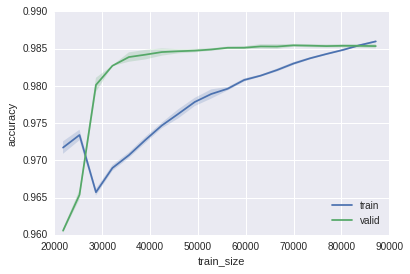

In [255]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (.ipynb или pdf) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревнование](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt) Kaggle Inclass.